In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json  # handle json file

from geopy.geocoders import Nominatim  # convert address to lat and long
import requests  # handle request url
from pandas.io.json import json_normalize  # transform json to dataframe

import matplotlib.cm as cm  # color map handling
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
import folium  # map rendering


## Loading the data

In [2]:
seoul_data = pd.read_csv('seoul_apartments.csv')
seoul_data = seoul_data.sample(200)
seoul_data.shape


(200, 19)

In [3]:
seoul_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 14577 to 4767
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CityCode      200 non-null    int64  
 1   Exit          200 non-null    int64  
 2   CodeT         200 non-null    int64  
 3   City          200 non-null    object 
 4   District      200 non-null    object 
 5   Ward          200 non-null    object 
 6   RoadCode      200 non-null    float64
 7   Road          200 non-null    object 
 8   UnderGround   200 non-null    int64  
 9   BuildingNo    200 non-null    int64  
 10  BuildingNoEx  200 non-null    int64  
 11  BuildingName  200 non-null    object 
 12  PostalCode    200 non-null    int64  
 13  UseType       200 non-null    object 
 14  Separate      200 non-null    int64  
 15  WardEx        200 non-null    object 
 16  RentPrice     200 non-null    int64  
 17  Lat           200 non-null    float64
 18  Long          200 non-nul

In [4]:
# Rename Latitude and Longitude
seoul_data_renamed = seoul_data.rename(columns={"Lat": "Longitude", "Long": "Latitude"})
seoul_data_renamed.head()

,CityCode,Exit,CodeT,City,District,Ward,RoadCode,Road,UnderGround,BuildingNo,BuildingNoEx,BuildingName,PostalCode,UseType,Separate,WardEx,RentPrice,Longitude,Latitude
14577,11590,5894,1159010100,서울특별시,동작구,노량진동,1.160000e+11,만양로13길,0,42,0,스카이빌,6926,주택,0,노량진제1동,1745,126.946458,37.508468
7727,11305,606,1130510100,서울특별시,강북구,미아동,1.130000e+11,오패산로52다길,0,27,5,진주빌라,1153,주택,0,송중동,1445,127.032221,37.624505
9087,11350,4309,1135010200,서울특별시,노원구,월계동,1.140000e+11,석계로13길,0,17,13,경원빌라,1896,주택,0,월계1동,1925,127.061155,37.620893
9486,11380,19537,1138010200,서울특별시,은평구,녹번동,1.140000e+11,은평로11길,0,26,6,경원빌라,3459,주택,0,녹번동,2375,126.923390,37.602303
8552,11305,31709,1130510400,서울특별시,강북구,우이동,1.130000e+11,삼양로169길,0,24,11,성보빌라,1002,주택,0,우이동,2030,127.010376,37.662300


In [5]:
## Drop unnecessary columns
lat = seoul_data_renamed["Latitude"]
seoul_data_renamed.drop(columns= ['CityCode', 'Exit','CodeT','RoadCode','UnderGround','BuildingNo','BuildingNoEx','UseType','Separate','WardEx'],axis=1, inplace=True)
seoul_data_renamed.head()

,City,District,Ward,Road,BuildingName,PostalCode,RentPrice,Longitude,Latitude
14577,서울특별시,동작구,노량진동,만양로13길,스카이빌,6926,1745,126.946458,37.508468
7727,서울특별시,강북구,미아동,오패산로52다길,진주빌라,1153,1445,127.032221,37.624505
9087,서울특별시,노원구,월계동,석계로13길,경원빌라,1896,1925,127.061155,37.620893
9486,서울특별시,은평구,녹번동,은평로11길,경원빌라,3459,2375,126.923390,37.602303
8552,서울특별시,강북구,우이동,삼양로169길,성보빌라,1002,2030,127.010376,37.662300


In [6]:
# Combine BuildingName & Postal code to neighborhood
seoul_data_renamed['Neighborhood'] = seoul_data_renamed['BuildingName'] + '_' + seoul_data_renamed['PostalCode'].astype(str)
seoul_data_final = seoul_data_renamed 
seoul_data_final.head()


,City,District,Ward,Road,BuildingName,PostalCode,RentPrice,Longitude,Latitude,Neighborhood
14577,서울특별시,동작구,노량진동,만양로13길,스카이빌,6926,1745,126.946458,37.508468,스카이빌_6926
7727,서울특별시,강북구,미아동,오패산로52다길,진주빌라,1153,1445,127.032221,37.624505,진주빌라_1153
9087,서울특별시,노원구,월계동,석계로13길,경원빌라,1896,1925,127.061155,37.620893,경원빌라_1896
9486,서울특별시,은평구,녹번동,은평로11길,경원빌라,3459,2375,126.923390,37.602303,경원빌라_3459
8552,서울특별시,강북구,우이동,삼양로169길,성보빌라,1002,2030,127.010376,37.662300,성보빌라_1002


In [7]:
# Check to confirm unique name of neighborhood
len(list(set(seoul_data_final['Neighborhood'])))

198

In [8]:
# Check the distribution of building across seoul
import folium

latitude = 37.5665
longitude = 126.9780

map_seoul = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(seoul_data_final['Latitude'], seoul_data_final['Longitude'], seoul_data_final['BuildingName'].astype(str)):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
       ).add_to(map_seoul)
map_seoul



In [9]:
## Define Foursquare Credentials and Version
CLIENT_ID = "DLC0HXVOYSXK3YKYAK1ZP3AIAUTLX2E5LHM3L3QSABVBSSLV"
CLIENT_SECRET = "N4HWXHSCZ5FDLQVUVP5MBRU0WJTCUIDPRJP0ZZWWYDCYWOPO"
ACCESS_TOKEN = "023U4LJHWCQV4AOFSRL3CCLSZZFX01UKOEFUSDE31BX4H1IE"
VERSION = '20210526'
LIMIT = 50 


In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    headers = {
        'Accept': 'application/json',
        'Authorization': 'fsq3v8nf/ywG0StCV5gUBVq6Ak4NTHmkBq8ZJepvOzKI0a4='
    }

    URL = 'https://api.foursquare.com/v3/places/search?ll={},{}&radius={}&limit={}'

    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):

        url = URL.format(lat, lng, radius, LIMIT)
        data = requests.get(url, headers=headers).json()
        # do stuff here to process venues_list
        for record in data['results']:
            venues_list.append({
                'Neighborhood': name,
                'Neighborhood Latitude': lat,
                'Neighborhood Longitude': lng,
                'Venue': record['name'],
                'Venue Latitude': record['geocodes']['main']['latitude'],
                'Venue Longitude': record['geocodes']['main']['longitude'],
                'Venue Category': record['categories'],
            })
    # do stuff here to create your dataframe
    nearby_venues = pd.DataFrame(venues_list)

    return(nearby_venues)

In [11]:
seoul_venues = getNearbyVenues(names=seoul_data_final['Neighborhood'],
                               latitudes=seoul_data_final['Latitude'],
                               longitudes=seoul_data_final['Longitude'])             


In [12]:
seoul_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,스카이빌_6926,37.508468,126.946458,커피인더스터디,37.508226,126.946017,"[{'id': 13034, 'name': 'Café', 'icon': {'prefi..."
1,스카이빌_6926,37.508468,126.946458,행복한 밥상,37.508161,126.947366,"[{'id': 13289, 'name': 'Korean Restaurant', 'i..."
2,스카이빌_6926,37.508468,126.946458,다래식당,37.506378,126.947649,"[{'id': 13289, 'name': 'Korean Restaurant', 'i..."
3,스카이빌_6926,37.508468,126.946458,모든 것은 당근케이크에서 시작됐다,37.509501,126.945585,"[{'id': 13034, 'name': 'Café', 'icon': {'prefi..."
4,스카이빌_6926,37.508468,126.946458,천외천,37.507342,126.944301,"[{'id': 13099, 'name': 'Chinese Restaurant', '..."


In [13]:
seoul_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            10000 non-null  object 
 1   Neighborhood Latitude   10000 non-null  float64
 2   Neighborhood Longitude  10000 non-null  float64
 3   Venue                   10000 non-null  object 
 4   Venue Latitude          10000 non-null  float64
 5   Venue Longitude         10000 non-null  float64
 6   Venue Category          10000 non-null  object 
dtypes: float64(4), object(3)
memory usage: 547.0+ KB


In [14]:
# Replace Venue Categories with empyt list with 0
for i in range(len(seoul_venues['Venue Category'])):
    if len(seoul_venues['Venue Category'][i]) > 0:
        seoul_venues['Venue Category'][i] = seoul_venues['Venue Category'][i][0]['name']
    else:
        seoul_venues['Venue Category'][i] = 0

/var/folders/3r/_7gc0b1x39182680qtp16wz80000gn/T/ipykernel_92634/3573682641.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seoul_venues['Venue Category'][i] = seoul_venues['Venue Category'][i][0]['name']
/var/folders/3r/_7gc0b1x39182680qtp16wz80000gn/T/ipykernel_92634/3573682641.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seoul_venues['Venue Category'][i] = 0


In [15]:
# Drop Venue Categories with 0
seoul_venues_final = seoul_venues[seoul_venues['Venue Category'] != 0]

In [16]:
seoul_venues_final.info()
seoul_venues_final = seoul_venues_final.reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9367 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            9367 non-null   object 
 1   Neighborhood Latitude   9367 non-null   float64
 2   Neighborhood Longitude  9367 non-null   float64
 3   Venue                   9367 non-null   object 
 4   Venue Latitude          9367 non-null   float64
 5   Venue Longitude         9367 non-null   float64
 6   Venue Category          9367 non-null   object 
dtypes: float64(4), object(3)
memory usage: 585.4+ KB


In [17]:
print('There are {} uniques categories.'.format(len(seoul_venues_final['Venue Category'].unique())))

There are 330 uniques categories.


## Group venue into 7 different categories

In [18]:
## Load the csv file contain 7 general categories
seoul_venues_cat = pd.read_csv('Seoul_venues_cat.csv')
seoul_venues_cat = seoul_venues_cat.fillna(1)  # replace NA with 1
seoul_venues_cat.head()

,Food and drink,Sports and leisure,Transport,Sightseeing and culture,Service and store,Entertainment,Lodging
0,African Restaurant,Athletics & Sports,Airport,Art Gallery,Antique Shop,Arcade,Boarding House
1,American Restaurant,Badminton Court,Airport Lounge,Art Museum,Auto Dealership,Bath House,Hostel
2,Asian Restaurant,Baseball Field,Airport Service,Arts & Crafts Store,Auto Workshop,Concert Hall,Hotel
3,Bakery,Baseball Stadium,Airport Terminal,Botanical Garden,Bagel Shop,General Entertainment,Residential Building (Apartment / Condo)
4,Bar,Basketball Court,Bridge,Cemetery,Board Shop,Indie Movie Theater,Resort


In [19]:
# Add a new column
seoul_venues_final['General Category'] = 0
seoul_venues_final.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,General Category
0,스카이빌_6926,37.508468,126.946458,커피인더스터디,37.508226,126.946017,Café,0
1,스카이빌_6926,37.508468,126.946458,행복한 밥상,37.508161,126.947366,Korean Restaurant,0
2,스카이빌_6926,37.508468,126.946458,다래식당,37.506378,126.947649,Korean Restaurant,0
3,스카이빌_6926,37.508468,126.946458,모든 것은 당근케이크에서 시작됐다,37.509501,126.945585,Café,0
4,스카이빌_6926,37.508468,126.946458,천외천,37.507342,126.944301,Chinese Restaurant,0


In [20]:
# Loop through all rows in seoul_venues_final df to assign General Category to each venue
for i in range(len(seoul_venues_final)):
    for j in range(len(seoul_venues_cat.columns)):
        if seoul_venues_final.loc[i,'Venue Category'] in seoul_venues_cat.iloc[:,j].values:
            # Add general category
            seoul_venues_final.loc[i, 'General Category'] = seoul_venues_cat.columns.values[j]

seoul_venues_final.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,General Category
0,스카이빌_6926,37.508468,126.946458,커피인더스터디,37.508226,126.946017,Café,Food and drink
1,스카이빌_6926,37.508468,126.946458,행복한 밥상,37.508161,126.947366,Korean Restaurant,Food and drink
2,스카이빌_6926,37.508468,126.946458,다래식당,37.506378,126.947649,Korean Restaurant,Food and drink
3,스카이빌_6926,37.508468,126.946458,모든 것은 당근케이크에서 시작됐다,37.509501,126.945585,Café,Food and drink
4,스카이빌_6926,37.508468,126.946458,천외천,37.507342,126.944301,Chinese Restaurant,Food and drink


In [21]:
# Remove row without any category
seoul_venues = seoul_venues_final[seoul_venues_final['General Category'] != 0]

print(set(seoul_venues['General Category']))


{'Transport', 'Entertainment', 'Sightseeing and culture', 'Sports and leisure', 'Service and store', 'Food and drink', 'Lodging'}


## Analyze each neighborhood


In [22]:
seoul_onehot = pd.get_dummies(seoul_venues[['General Category']], prefix="", prefix_sep="")

seoul_onehot.insert(0,'Neighborhood',seoul_venues['Neighborhood'],True)
print(seoul_onehot.shape)
seoul_onehot.head()

(6347, 8)


,Neighborhood,Entertainment,Food and drink,Lodging,Service and store,Sightseeing and culture,Sports and leisure,Transport
0,스카이빌_6926,0,1,0,0,0,0,0
1,스카이빌_6926,0,1,0,0,0,0,0
2,스카이빌_6926,0,1,0,0,0,0,0
3,스카이빌_6926,0,1,0,0,0,0,0
4,스카이빌_6926,0,1,0,0,0,0,0


## Group the neighborhood

In [23]:
# Grouped by total number of general categories
seoul_grouped_sum = seoul_onehot.groupby('Neighborhood').sum().reset_index()
print(seoul_grouped_sum.shape)
seoul_grouped_sum.head(40)


(198, 8)


,Neighborhood,Entertainment,Food and drink,Lodging,Service and store,Sightseeing and culture,Sports and leisure,Transport
0,SY파크힐_4502,3,37,0,0,2,1,0
1,각산타운_4052,3,39,0,0,1,1,0
2,경신빌라_7679,0,23,0,1,0,0,0
3,경원빌라_1896,0,32,0,1,0,1,0
4,경원빌라_3459,0,30,0,5,0,1,0
5,골든빌_5403,1,26,0,3,0,1,0
6,광명빌라_1717,0,27,0,0,0,0,0
7,광영빌딩_7773,1,37,1,0,0,0,0
8,광진빌딩_5637,2,30,0,0,4,2,0
9,그린빌라_3041,0,36,0,0,0,0,0


In [24]:
# Grouped by mean of general category
seoul_grouped_mean = seoul_onehot.groupby('Neighborhood').mean().reset_index()
print(seoul_grouped_mean.shape)
seoul_grouped_mean.head(10)

(198, 8)


,Neighborhood,Entertainment,Food and drink,Lodging,Service and store,Sightseeing and culture,Sports and leisure,Transport
0,SY파크힐_4502,0.069767,0.860465,0.000000,0.000000,0.046512,0.023256,0.0
1,각산타운_4052,0.068182,0.886364,0.000000,0.000000,0.022727,0.022727,0.0
2,경신빌라_7679,0.000000,0.958333,0.000000,0.041667,0.000000,0.000000,0.0
3,경원빌라_1896,0.000000,0.941176,0.000000,0.029412,0.000000,0.029412,0.0
4,경원빌라_3459,0.000000,0.833333,0.000000,0.138889,0.000000,0.027778,0.0
5,골든빌_5403,0.032258,0.838710,0.000000,0.096774,0.000000,0.032258,0.0
6,광명빌라_1717,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
7,광영빌딩_7773,0.025641,0.948718,0.025641,0.000000,0.000000,0.000000,0.0
8,광진빌딩_5637,0.052632,0.789474,0.000000,0.000000,0.105263,0.052632,0.0
9,그린빌라_3041,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0


## Create a new dataframe and display top 7 general catetories¶


In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [26]:
import numpy as np

num_top_venues = 7
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = seoul_grouped_mean['Neighborhood']

for ind in np.arange(seoul_grouped_mean.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seoul_grouped_mean.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,SY파크힐_4502,Food and drink,Entertainment,Sightseeing and culture,Sports and leisure,Lodging,Service and store,Transport
1,각산타운_4052,Food and drink,Entertainment,Sightseeing and culture,Sports and leisure,Lodging,Service and store,Transport
2,경신빌라_7679,Food and drink,Service and store,Entertainment,Lodging,Sightseeing and culture,Sports and leisure,Transport
3,경원빌라_1896,Food and drink,Service and store,Sports and leisure,Entertainment,Lodging,Sightseeing and culture,Transport
4,경원빌라_3459,Food and drink,Service and store,Sports and leisure,Entertainment,Lodging,Sightseeing and culture,Transport
5,골든빌_5403,Food and drink,Service and store,Entertainment,Sports and leisure,Lodging,Sightseeing and culture,Transport
6,광명빌라_1717,Food and drink,Entertainment,Lodging,Service and store,Sightseeing and culture,Sports and leisure,Transport
7,광영빌딩_7773,Food and drink,Entertainment,Lodging,Service and store,Sightseeing and culture,Sports and leisure,Transport
8,광진빌딩_5637,Food and drink,Sightseeing and culture,Entertainment,Sports and leisure,Lodging,Service and store,Transport
9,그린빌라_3041,Food and drink,Entertainment,Lodging,Service and store,Sightseeing and culture,Sports and leisure,Transport


## Clustering neighborhood

In [27]:
# Set the df for modeling
seoul_grouped_clustering = seoul_grouped_mean.drop('Neighborhood', 1)

kmeans_kwargs = {
    'init': 'random',
    'n_init': 12,
    'max_iter': 300,
    'random_state': 42,
}

# A list to hold SSE values for each k
sse = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)  # **unpacking operator
    kmeans.fit(seoul_grouped_clustering)
    sse.append(kmeans.inertia_)



/var/folders/3r/_7gc0b1x39182680qtp16wz80000gn/T/ipykernel_92634/2576339978.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  seoul_grouped_clustering = seoul_grouped_mean.drop('Neighborhood', 1)


## Visualize the k means accuracy with k value

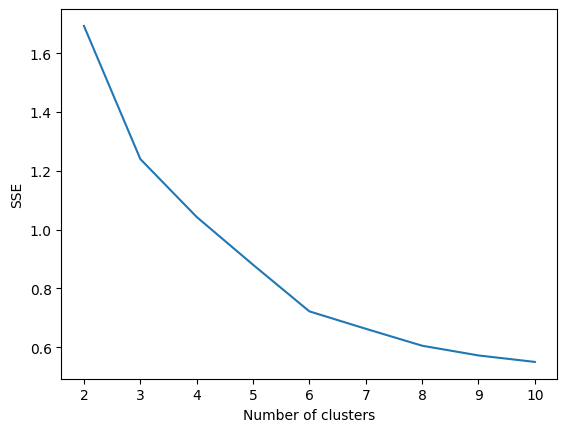

In [28]:
plt.plot(range(2,11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()


In [29]:
# From above chart, k=6 seems to give resonable accuracy
# Build model again using k=6
kclusters = 6
seoul_grouped_clustering = seoul_grouped_mean.drop('Neighborhood', 1)

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seoul_grouped_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20]

/var/folders/3r/_7gc0b1x39182680qtp16wz80000gn/T/ipykernel_92634/3845050542.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  seoul_grouped_clustering = seoul_grouped_mean.drop('Neighborhood', 1)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([4, 4, 2, 2, 0, 0, 2, 2, 3, 2, 4, 4, 0, 2, 0, 2, 2, 1, 3, 3],
      dtype=int32)

In [30]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

seoul_merged = seoul_data_final

#seoul_grouped with seoul_data to add latitude/longitude for each neighborhood
seoul_merged = seoul_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

seoul_merged.head() 


,City,District,Ward,Road,BuildingName,PostalCode,RentPrice,Longitude,Latitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
14577,서울특별시,동작구,노량진동,만양로13길,스카이빌,6926,1745,126.946458,37.508468,스카이빌_6926,0,Food and drink,Service and store,Entertainment,Sightseeing and culture,Lodging,Sports and leisure,Transport
7727,서울특별시,강북구,미아동,오패산로52다길,진주빌라,1153,1445,127.032221,37.624505,진주빌라_1153,4,Food and drink,Service and store,Entertainment,Sports and leisure,Lodging,Sightseeing and culture,Transport
9087,서울특별시,노원구,월계동,석계로13길,경원빌라,1896,1925,127.061155,37.620893,경원빌라_1896,2,Food and drink,Service and store,Sports and leisure,Entertainment,Lodging,Sightseeing and culture,Transport
9486,서울특별시,은평구,녹번동,은평로11길,경원빌라,3459,2375,126.923390,37.602303,경원빌라_3459,0,Food and drink,Service and store,Sports and leisure,Entertainment,Lodging,Sightseeing and culture,Transport
8552,서울특별시,강북구,우이동,삼양로169길,성보빌라,1002,2030,127.010376,37.662300,성보빌라_1002,0,Food and drink,Service and store,Entertainment,Sightseeing and culture,Lodging,Sports and leisure,Transport


In [31]:
seoul_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 14577 to 4767
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   City                   200 non-null    object 
 1   District               200 non-null    object 
 2   Ward                   200 non-null    object 
 3   Road                   200 non-null    object 
 4   BuildingName           200 non-null    object 
 5   PostalCode             200 non-null    int64  
 6   RentPrice              200 non-null    int64  
 7   Longitude              200 non-null    float64
 8   Latitude               200 non-null    float64
 9   Neighborhood           200 non-null    object 
 10  Cluster Labels         200 non-null    int32  
 11  1st Most Common Venue  200 non-null    object 
 12  2nd Most Common Venue  200 non-null    object 
 13  3rd Most Common Venue  200 non-null    object 
 14  4th Most Common Venue  200 non-null    object 
 15  5

## Visualize the resulting cluster

In [33]:
latitude = 37.5665
longitude = 126.9780

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seoul_merged['Latitude'], seoul_merged['Longitude'], seoul_merged['Neighborhood'], seoul_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


### Cluster 1: Sight-Seeing and Entertainment
- For **sight-seeing** and **entertainment** lovers 

In [34]:
seoul_clust1 = seoul_merged.loc[seoul_merged['Cluster Labels'] == 0, seoul_merged.columns[[1] + list(range(5, seoul_merged.shape[1]))]]
seoul_clust1.head()

,District,PostalCode,RentPrice,Longitude,Latitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
14577,동작구,6926,1745,126.946458,37.508468,스카이빌_6926,0,Food and drink,Service and store,Entertainment,Sightseeing and culture,Lodging,Sports and leisure,Transport
9486,은평구,3459,2375,126.923390,37.602303,경원빌라_3459,0,Food and drink,Service and store,Sports and leisure,Entertainment,Lodging,Sightseeing and culture,Transport
8552,강북구,1002,2030,127.010376,37.662300,성보빌라_1002,0,Food and drink,Service and store,Entertainment,Sightseeing and culture,Lodging,Sports and leisure,Transport
17964,송파구,5665,1810,127.114656,37.508686,한스빌_5665,0,Food and drink,Sports and leisure,Service and store,Entertainment,Lodging,Sightseeing and culture,Transport
9999,은평구,3404,2690,126.921055,37.604578,인성빌라_3404,0,Food and drink,Service and store,Sports and leisure,Sightseeing and culture,Entertainment,Lodging,Transport


In [54]:
for column in seoul_clust1[["1st Most Common Venue", "2nd Most Common Venue", "3rd Most Common Venue", "4th Most Common Venue", "5th Most Common Venue"]]:
    column_obj = seoul_clust1[column]
    print(column_obj.value_counts())

Food and drink    42
Name: 1st Most Common Venue, dtype: int64
Service and store     41
Sports and leisure     1
Name: 2nd Most Common Venue, dtype: int64
Entertainment              19
Sports and leisure         13
Sightseeing and culture     7
Transport                   2
Service and store           1
Name: 3rd Most Common Venue, dtype: int64
Entertainment              14
Sightseeing and culture    12
Sports and leisure          9
Lodging                     6
Transport                   1
Name: 4th Most Common Venue, dtype: int64
Lodging                    23
Entertainment               9
Sightseeing and culture     8
Sports and leisure          1
Transport                   1
Name: 5th Most Common Venue, dtype: int64


### Cluster 2: Services and Entertainment
- Easily accessible to **services and stores**
- For **entertainment** lovers

In [38]:
seoul_clust2 = seoul_merged.loc[seoul_merged['Cluster Labels'] == 1, seoul_merged.columns[[1] + list(range(5, seoul_merged.shape[1]))]]
seoul_clust2


,District,PostalCode,RentPrice,Longitude,Latitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
14358,영등포구,7201,580,126.891402,37.542176,리치빌_7201,1,Food and drink,Service and store,Sports and leisure,Entertainment,Sightseeing and culture,Lodging,Transport
14789,동작구,7045,880,126.939257,37.495736,태성빌라_7045,1,Food and drink,Sightseeing and culture,Service and store,Entertainment,Lodging,Sports and leisure,Transport
10358,서대문구,3652,1395,126.933941,37.585254,현대맨션_3652,1,Food and drink,Service and store,Sports and leisure,Transport,Entertainment,Lodging,Sightseeing and culture
14820,동작구,7044,2855,126.935335,37.496437,낙원빌라_7044,1,Food and drink,Sightseeing and culture,Service and store,Sports and leisure,Entertainment,Lodging,Transport
16627,서초구,6678,2165,126.989733,37.481039,미도빌라_6678,1,Food and drink,Sightseeing and culture,Service and store,Sports and leisure,Entertainment,Lodging,Transport


In [39]:
for column in seoul_clust2[["1st Most Common Venue", "2nd Most Common Venue", "3rd Most Common Venue", "4th Most Common Venue", "5th Most Common Venue"]]:
    column_obj = seoul_clust2[column]
    print(column_obj.value_counts())

Food and drink    5
Name: 1st Most Common Venue, dtype: int64
Sightseeing and culture    3
Service and store          2
Name: 2nd Most Common Venue, dtype: int64
Service and store     3
Sports and leisure    2
Name: 3rd Most Common Venue, dtype: int64
Entertainment         2
Sports and leisure    2
Transport             1
Name: 4th Most Common Venue, dtype: int64
Entertainment              3
Sightseeing and culture    1
Lodging                    1
Name: 5th Most Common Venue, dtype: int64


### Cluster 3: Sight-Seeing and Services
- For sight-seeing lovers
- Easily accessible to services and stores

In [40]:
seoul_clust3 = seoul_merged.loc[seoul_merged['Cluster Labels'] == 2, seoul_merged.columns[[1] + list(range(5, seoul_merged.shape[1]))]]
seoul_clust3.head()

,District,PostalCode,RentPrice,Longitude,Latitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
9087,노원구,1896,1925,127.061155,37.620893,경원빌라_1896,2,Food and drink,Service and store,Sports and leisure,Entertainment,Lodging,Sightseeing and culture,Transport
8265,강북구,1044,740,127.017675,37.649066,동원빌라_1044,2,Food and drink,Service and store,Sports and leisure,Entertainment,Lodging,Sightseeing and culture,Transport
9176,노원구,1848,2940,127.076072,37.622488,상아빌라_1848,2,Food and drink,Service and store,Sightseeing and culture,Entertainment,Lodging,Sports and leisure,Transport
3303,용산구,4403,540,127.001224,37.533729,대원빌라_4403,2,Food and drink,Entertainment,Lodging,Service and store,Sightseeing and culture,Sports and leisure,Transport
7630,강북구,1182,1205,127.013663,37.624656,은혜빌_1182,2,Food and drink,Entertainment,Lodging,Service and store,Sightseeing and culture,Sports and leisure,Transport


In [41]:
for column in seoul_clust3[["1st Most Common Venue", "2nd Most Common Venue", "3rd Most Common Venue", "4th Most Common Venue", "5th Most Common Venue"]]:
    column_obj = seoul_clust3[column]
    print(column_obj.value_counts())

Food and drink    58
Name: 1st Most Common Venue, dtype: int64
Entertainment              26
Service and store          18
Sightseeing and culture    10
Sports and leisure          4
Name: 2nd Most Common Venue, dtype: int64
Entertainment              24
Lodging                    16
Sports and leisure          8
Sightseeing and culture     5
Service and store           5
Name: 3rd Most Common Venue, dtype: int64
Lodging               33
Service and store     16
Entertainment          7
Sports and leisure     2
Name: 4th Most Common Venue, dtype: int64
Sightseeing and culture    33
Service and store          16
Lodging                     8
Entertainment               1
Name: 5th Most Common Venue, dtype: int64


### Cluster 4: Service, Entertainment, and Lodging 

In [42]:
seoul_clust4 = seoul_merged.loc[seoul_merged['Cluster Labels'] == 3, seoul_merged.columns[[1] + list(range(5, seoul_merged.shape[1]))]]
seoul_clust4.head()


,District,PostalCode,RentPrice,Longitude,Latitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
2561,용산구,4305,2230,126.964526,37.550629,종로떡집_4305,3,Food and drink,Sightseeing and culture,Entertainment,Service and store,Sports and leisure,Lodging,Transport
831,종로구,3089,1540,127.009494,37.576443,창림아파트_3089,3,Food and drink,Sightseeing and culture,Service and store,Sports and leisure,Entertainment,Lodging,Transport
1740,중구,4595,1215,127.007456,37.548044,남산타운_4595,3,Food and drink,Sports and leisure,Sightseeing and culture,Entertainment,Lodging,Service and store,Transport
1918,중구,4601,585,127.006351,37.550547,성지타운_4601,3,Food and drink,Sightseeing and culture,Sports and leisure,Service and store,Entertainment,Lodging,Transport
199,종로구,3038,1470,126.966630,37.579902,문화빌라_3038,3,Food and drink,Sightseeing and culture,Entertainment,Lodging,Service and store,Sports and leisure,Transport


In [43]:
for column in seoul_clust4[["1st Most Common Venue", "2nd Most Common Venue", "3rd Most Common Venue", "4th Most Common Venue", "5th Most Common Venue"]]:
    column_obj = seoul_clust4[column]
    print(column_obj.value_counts())

Food and drink    20
Name: 1st Most Common Venue, dtype: int64
Sightseeing and culture    16
Service and store           3
Sports and leisure          1
Name: 2nd Most Common Venue, dtype: int64
Entertainment              6
Service and store          6
Sightseeing and culture    4
Sports and leisure         3
Transport                  1
Name: 3rd Most Common Venue, dtype: int64
Service and store     7
Sports and leisure    6
Entertainment         6
Lodging               1
Name: 4th Most Common Venue, dtype: int64
Entertainment         7
Sports and leisure    6
Lodging               5
Service and store     1
Transport             1
Name: 5th Most Common Venue, dtype: int64


## Cluster 5 - All Available
- Service and stores, Gyms, and areas for entertainment and leisure are all available

In [44]:
seoul_clust5 = seoul_merged.loc[seoul_merged['Cluster Labels'] == 4, seoul_merged.columns[[1] + list(range(5, seoul_merged.shape[1]))]]
seoul_clust5.head()

,District,PostalCode,RentPrice,Longitude,Latitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
7727,강북구,1153,1445,127.032221,37.624505,진주빌라_1153,4,Food and drink,Service and store,Entertainment,Sports and leisure,Lodging,Sightseeing and culture,Transport
16438,관악구,8781,2715,126.936520,37.478967,삼일빌라_8781,4,Food and drink,Transport,Sightseeing and culture,Sports and leisure,Entertainment,Lodging,Service and store
19539,강동구,5406,1800,127.132221,37.527531,신성연립_5406,4,Food and drink,Service and store,Entertainment,Lodging,Sightseeing and culture,Sports and leisure,Transport
10012,은평구,3440,1405,126.907550,37.593464,스카이빌_3440,4,Food and drink,Service and store,Sports and leisure,Entertainment,Lodging,Sightseeing and culture,Transport
19033,송파구,5777,1875,127.149513,37.493805,성지빌라_5777,4,Food and drink,Entertainment,Service and store,Lodging,Sightseeing and culture,Sports and leisure,Transport


In [45]:
for column in seoul_clust5[["1st Most Common Venue", "2nd Most Common Venue", "3rd Most Common Venue", "4th Most Common Venue", "5th Most Common Venue"]]:
    column_obj = seoul_clust5[column]
    print(column_obj.value_counts())

Food and drink    72
Name: 1st Most Common Venue, dtype: int64
Service and store          31
Entertainment              23
Sightseeing and culture    13
Sports and leisure          4
Transport                   1
Name: 2nd Most Common Venue, dtype: int64
Service and store          23
Sightseeing and culture    22
Entertainment              17
Sports and leisure         10
Name: 3rd Most Common Venue, dtype: int64
Entertainment              24
Lodging                    17
Sports and leisure         15
Sightseeing and culture    10
Service and store           4
Transport                   2
Name: 4th Most Common Venue, dtype: int64
Lodging                    41
Sightseeing and culture    14
Entertainment               8
Service and store           5
Sports and leisure          4
Name: 5th Most Common Venue, dtype: int64


### Cluster 6: For Entertainment Lovers

In [46]:
seoul_clust6 = seoul_merged.loc[seoul_merged['Cluster Labels'] == 5, seoul_merged.columns[[1] + list(range(5, seoul_merged.shape[1]))]]
seoul_clust6.head()

,District,PostalCode,RentPrice,Longitude,Latitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
525,종로구,3085,790,127.005328,37.583459,동악주택_3085,5,Food and drink,Entertainment,Sightseeing and culture,Service and store,Lodging,Sports and leisure,Transport
452,종로구,3082,1535,127.001057,37.578723,예림빌리지_3082,5,Food and drink,Entertainment,Sightseeing and culture,Service and store,Lodging,Sports and leisure,Transport
513,종로구,3085,1015,127.005287,37.585392,탑빌라_3085,5,Food and drink,Entertainment,Sightseeing and culture,Service and store,Lodging,Sports and leisure,Transport


In [53]:
for column in seoul_clust6[["1st Most Common Venue", "2nd Most Common Venue", "3rd Most Common Venue", "4th Most Common Venue", "5th Most Common Venue"]]:
    column_obj = seoul_clust6[column]
    print(column_obj.value_counts())

Food and drink    3
Name: 1st Most Common Venue, dtype: int64
Entertainment    3
Name: 2nd Most Common Venue, dtype: int64
Sightseeing and culture    3
Name: 3rd Most Common Venue, dtype: int64
Service and store    3
Name: 4th Most Common Venue, dtype: int64
Lodging    3
Name: 5th Most Common Venue, dtype: int64


## Best apartment based on my preference

In [61]:
# Want apartment that's close to areas for entertainment and service/stores
# budget of 1000$/month for renting a house
# Want to live in 강북구 (Kangbuk District)

cus_group = 5      
cus_rent = 3000    # max 2000$/month
cus_loc = '강북구'  # desired district selected

cus_data = seoul_merged[(seoul_merged['Cluster Labels']==(cus_group-1)) & (seoul_merged['RentPrice']<=cus_rent) & (seoul_merged['District']==cus_loc)]

print('Number of place = ',len(cus_data))
cus_data

Number of place =  11


,City,District,Ward,Road,BuildingName,PostalCode,RentPrice,Longitude,Latitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
7727,서울특별시,강북구,미아동,오패산로52다길,진주빌라,1153,1445,127.032221,37.624505,진주빌라_1153,4,Food and drink,Service and store,Entertainment,Sports and leisure,Lodging,Sightseeing and culture,Transport
7794,서울특별시,강북구,미아동,오현로9길,동성주택,1153,1500,127.032002,37.623253,동성주택_1153,4,Food and drink,Entertainment,Service and store,Sports and leisure,Lodging,Sightseeing and culture,Transport
8532,서울특별시,강북구,우이동,삼양로149길,인성빌라,1006,2560,127.010828,37.655679,인성빌라_1006,4,Food and drink,Service and store,Sightseeing and culture,Entertainment,Lodging,Sports and leisure,Transport
8498,서울특별시,강북구,수유동,화계사길,설악빌라,1095,1565,127.010057,37.633545,설악빌라_1095,4,Food and drink,Entertainment,Service and store,Sightseeing and culture,Lodging,Sports and leisure,Transport
8211,서울특별시,강북구,수유동,삼각산로18길,현대빌라,1083,1100,127.014541,37.640796,현대빌라_1083,4,Food and drink,Service and store,Sports and leisure,Entertainment,Lodging,Sightseeing and culture,Transport
7877,서울특별시,강북구,번동,덕릉로40가길,진주빌라,1134,990,127.027688,37.635042,진주빌라_1134,4,Food and drink,Service and store,Entertainment,Lodging,Sightseeing and culture,Sports and leisure,Transport
8107,서울특별시,강북구,수유동,삼각산로,서광빌리지,1077,2580,127.020787,37.642763,서광빌리지_1077,4,Food and drink,Entertainment,Service and store,Sports and leisure,Lodging,Sightseeing and culture,Transport
8384,서울특별시,강북구,수유동,인수봉로55길,성지,1024,2695,127.009871,37.636040,성지_1024,4,Food and drink,Entertainment,Service and store,Sightseeing and culture,Lodging,Sports and leisure,Transport
7612,서울특별시,강북구,미아동,삼양로58길,성진주택,1123,865,127.020471,37.627112,성진주택_1123,4,Food and drink,Entertainment,Sports and leisure,Lodging,Service and store,Sightseeing and culture,Transport
8326,서울특별시,강북구,수유동,수유로17나길,화인하우스,1079,2765,127.017952,37.637996,화인하우스_1079,4,Food and drink,Entertainment,Service and store,Sports and leisure,Lodging,Sightseeing and culture,Transport


In [62]:
import folium

latitude = 37.5665
longitude = 126.9780

map_myApt = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(cus_data['Latitude'], cus_data['Longitude'], cus_data['BuildingName'].astype(str)):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
       ).add_to(map_myApt)
map_myApt